In [22]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.special
import scipy.stats as stats
import pymc as pm
import seaborn as sns
import pandas as pd

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trace', 'summer', 'winter']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Question 1
A wildlife ecologist contacts you. She works for a large regional park. They have been having problems with wolves attacking small pets in campgrounds and hiking trails. They are interested in exploring the option of relocating the wolves. In order to make a recomendation, they first need to know more about how the wolves wander near their den. They know the wolf den moves between two seasonal locations. They want to know how far, on average, wolves wander from their den for both the summer and winter. The parks staff has kept records over the past five years of any contact with wolves. Any time a wolf or their tracks are sighted, a position is recorded along with the date. The positions are in kilometers relative to center of the park, with positive `y` pointing north and positive `x` pointing east. You agree to help, and the ecologist sends you a CSV file with the wolf data.




# A
Load the data from the file `wolves.csv` in the data folder into a Pandas dataframe. There are 3 colunns: `x`, `y`, and `date`. Look through the data and locate any rows that have been corrupted, improperly formated, or have incomplete data. Filter out any that you find, and create a new dataframe with the cleaned data.

# B
Sort the observations between summertime and wintertime. Chose date ranges that divide the two seasons based on looking/plotting the data. Make sure all of the observations are used (none are left out).

# C
Plot the positions $x$ vs $y$, for both winter and summer, as a scatter plot. Label the axes and make it look nice.

# D
Plot a probability density function (using a kernel density estimator) for both $x$ and $y$, for both winter and summer.

# E
Using the resulting plot from the previous part, make a guess about what distribution you should use as a model of $x_i$ and $y_i$. Your model should depend on the position of the summertime and wintertime wolf den.

# F
Propose informative priors for any parameters in the model, create prior predictive plots, and describe the reasoning you used to justify your choices.

# G
Use MCMC sampling (use 4 chains each with 1000 samples) to estimate the posterior. Plot the corresponding posterior probability density function for the mean squared distance of wolf sighting from the den position for both winter and summer and for both north/south and east/west distance (using a KDE). That means four total KDE plots. Label the axes and make it look nice.



**SOLUTION**

A.
 **Load + clean the wolf data**

Our Goal:

We need a clean dataset of wolf sightings with valid numeric coordinates and valid dates, because corrupted rows can distort season splitting, KDEs, and Bayesian inference.

What I did (and why):

We Loaded wolves.csv into a DataFrame.

Forced each column into the correct type:

x, y → numeric (to_numeric(..., errors="coerce"))

date → datetime (to_datetime(..., errors="coerce"))

Dropped rows where any of x, y, or date failed conversion (became NaN).

Sorted by date so season logic and time plots reflect real chronology.

What I observed:

After coercion + dropping missing/invalid rows, the dataset became consistent and plottable.

This prevents downstream plots/models from being driven by formatting errors.


In [23]:
path_to_data = 'https://raw.githubusercontent.com/newby-jay/MATH509-Winter2026-JupyterNotebooks/main/Data/'
data = pd.read_csv(path_to_data + 'wolves.csv', index_col=0)
data
before_n = data.shape[0]
data["x"]    = pd.to_numeric(data["x"], errors="coerce")
data["y"]    = pd.to_numeric(data["y"], errors="coerce")
data["date"] = pd.to_datetime(data["date"], errors="coerce")

clean = data.dropna(subset=["x","y","date"]).sort_values("date").reset_index(drop=True)
after_n = clean.shape[0]
dropped_obs = before_n - after_n
print("Total observations =", before_n, "->", after_n, "= after cleaning")
print("Dropped", dropped_obs, "observations")
clean


Total observations = 522 -> 519 = after cleaning
Dropped 3 observations


/tmp/ipython-input-1209070116.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["date"] = pd.to_datetime(data["date"], errors="coerce")


,x,y,date
0,110.9,-75.0,2010-01-02
1,-74.0,-264.0,2010-01-03
2,78.6,-28.6,2010-01-06
3,3.5,-187.1,2010-01-07
4,56.1,-50.9,2010-01-09
...,...,...,...
514,41.6,-184.3,2013-12-15
515,134.7,-28.4,2013-12-21
516,81.0,-207.7,2013-12-28
517,84.0,-64.1,2013-12-29


B.
 **Split into summer vs winter** **(seasonal den locations)**

Goal

The park staff suspects the den shifts between two seasonal locations, so the movement distribution should be season-dependent.

**What I did**

Plotted x and y against date (time series scatter).

Based on the repeating pattern across years, defined:

Summer: May–October (month in [5..10])

Winter: November–April (month in [11,12,1,2,3,4])

Verified that all clean observations are assigned:

summer_n + winter_n == clean_n

**What I observed from the time plot**

The coordinates clearly exhibit a seasonal pattern across years (especially y), consistent with the den shifting location between seasons.

The split is justified because the structure repeats over multiple years, not just noise.

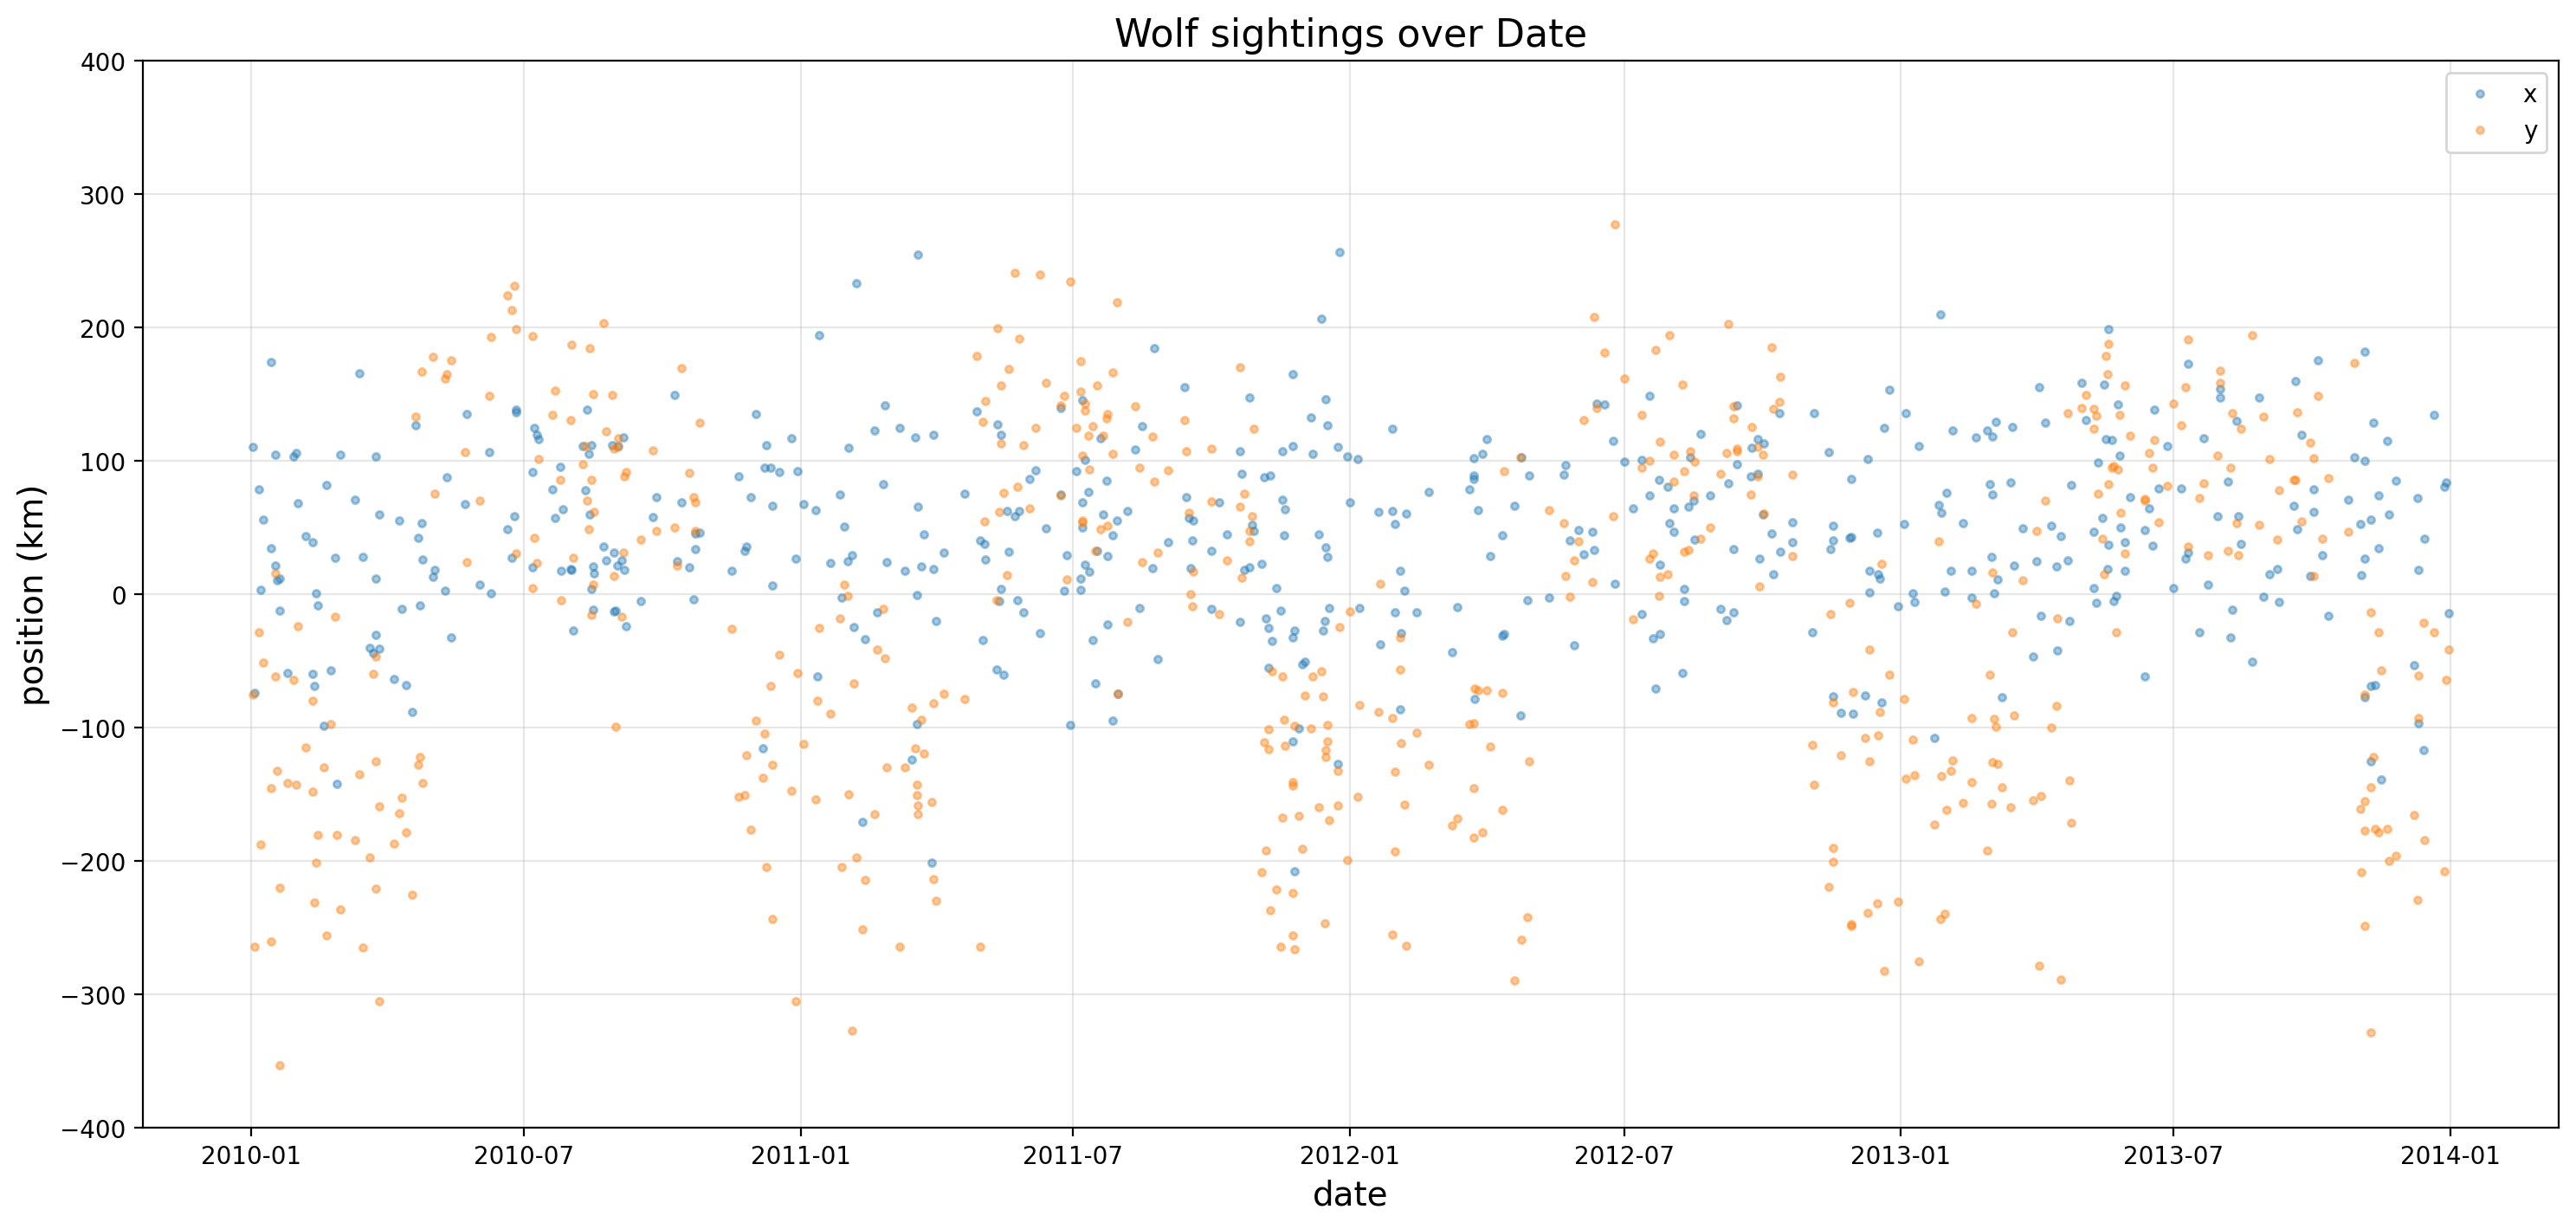

summer n = 253
winter n = 266
Total clean observations =  519
summer + winter =  519


In [24]:
figure(1, [18,8])
plot(clean["date"], clean["x"], ".", alpha=0.4, label="x")
plot(clean["date"], clean["y"], ".", alpha=0.4, label="y")
xlabel("date", fontsize=14)
ylabel("position (km)", fontsize=14)
title("Wolf sightings over Date", fontsize=16)
legend()
grid(alpha=0.3)
ylim([-400, 400])
show()

#  Let Summer be May to October and  Winter be November to April
m = clean["date"].dt.month
summer = clean[(m >= 5) & (m <= 10)].copy()
winter = clean[(m < 5) | (m > 10)].copy()

print("summer n =", summer.shape[0])
print("winter n =", winter.shape[0])

print("Total clean observations = ", clean.shape[0])
print("summer + winter = ", summer.shape[0] + winter.shape[0])

C.
**Scatter plot of positions (x vs y) by season**

**Goal**

Visually compare where wolves are observed relative to the park coordinates, and check if the data form distinct seasonal clusters.

**What I did**

Plotted x vs y with separate colors for summer and winter.

Used axis("equal") to preserve geometry (so distances aren’t visually distorted).

**What I observed (our plot is very informative)**

The points form two distinct clusters separated mainly in y:

Summer cluster: mostly positive y (north)

Winter cluster: mostly negative y (south)

The x distributions overlap more than y, meaning:

The den shift is dominated by a north/south relocation (change in y) rather than east/west.

**Interpretation**

This strongly supports a model where the mean location (den position) differs by season:

Summer den center ≈ (𝜇𝑥,𝑆,𝜇𝑦,𝑆)

Winter den center ≈ (𝜇𝑥,W,𝜇𝑦,W)



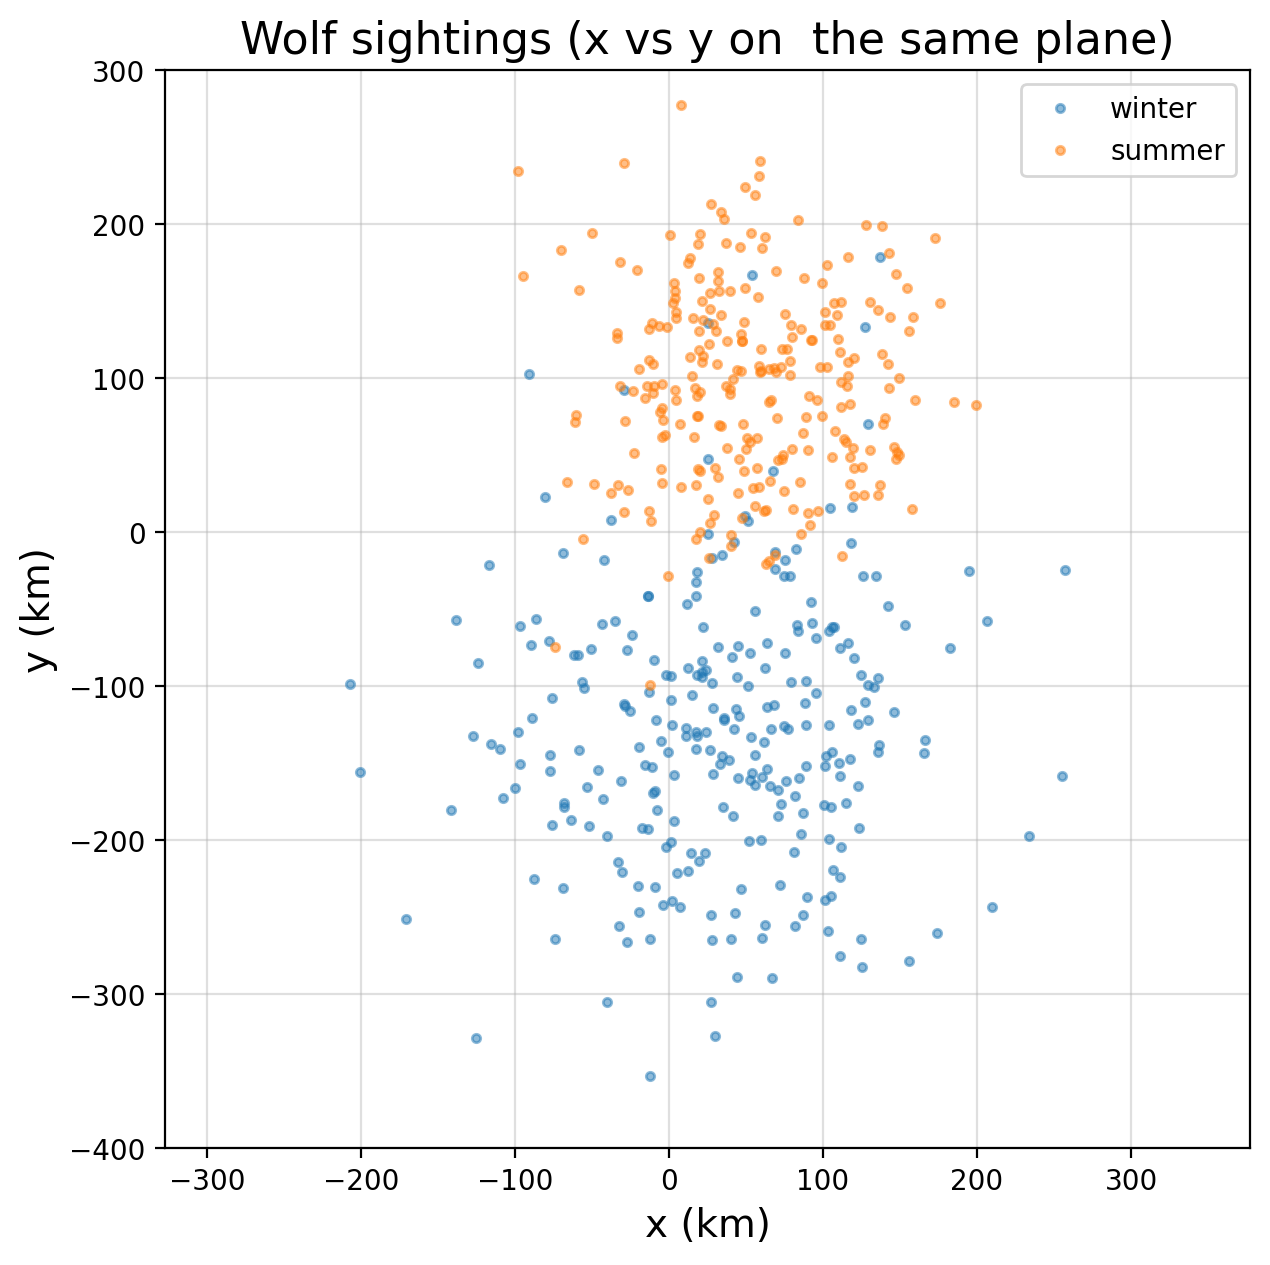

In [25]:
figure(1, [7,7])
plot(winter["x"], winter["y"], ".", alpha=0.5, label="winter")
plot(summer["x"], summer["y"], ".", alpha=0.5, label="summer")
xlabel("x (km)", fontsize=14)
ylabel("y (km)", fontsize=14)
title("Wolf sightings (x vs y on  the same plane)", fontsize=16)
axis("equal")
xlim([-250, 300])
ylim([-400, 300])
legend()
grid(alpha=0.4)
show()

D.
 **KDEs for x and y by season**

Goal

Use KDEs to infer the shape of the distributions for each coordinate within each season (e.g., Normal vs heavy-tailed vs multimodal).

**What We did**

Built KDE overlays for:

x (winter vs summer)

y (winter vs summer)


**Observation**:

For x:

The KDE curves are unimodal and fairly bell-shaped, with winter slightly more spread out.

This suggests a Normal-like marginal distribution for x (season-specific mean/variance).

For y:

The KDE plot’s x-axis stretches to a huge range (up to ~90,000 km), and the density is compressed near 0.

This is a classic sign of a single extreme outlier (numerically valid but physically unrealistic) dominating the plotting scale.

Interpretation

The x KDE supports a Normal assumption.

The y KDE output indicates that before trusting distribution shape for y, we should handle the extreme outlier (e.g., filter to a plausible park range like |y| < 400 km, consistent with our other plots’ limits).

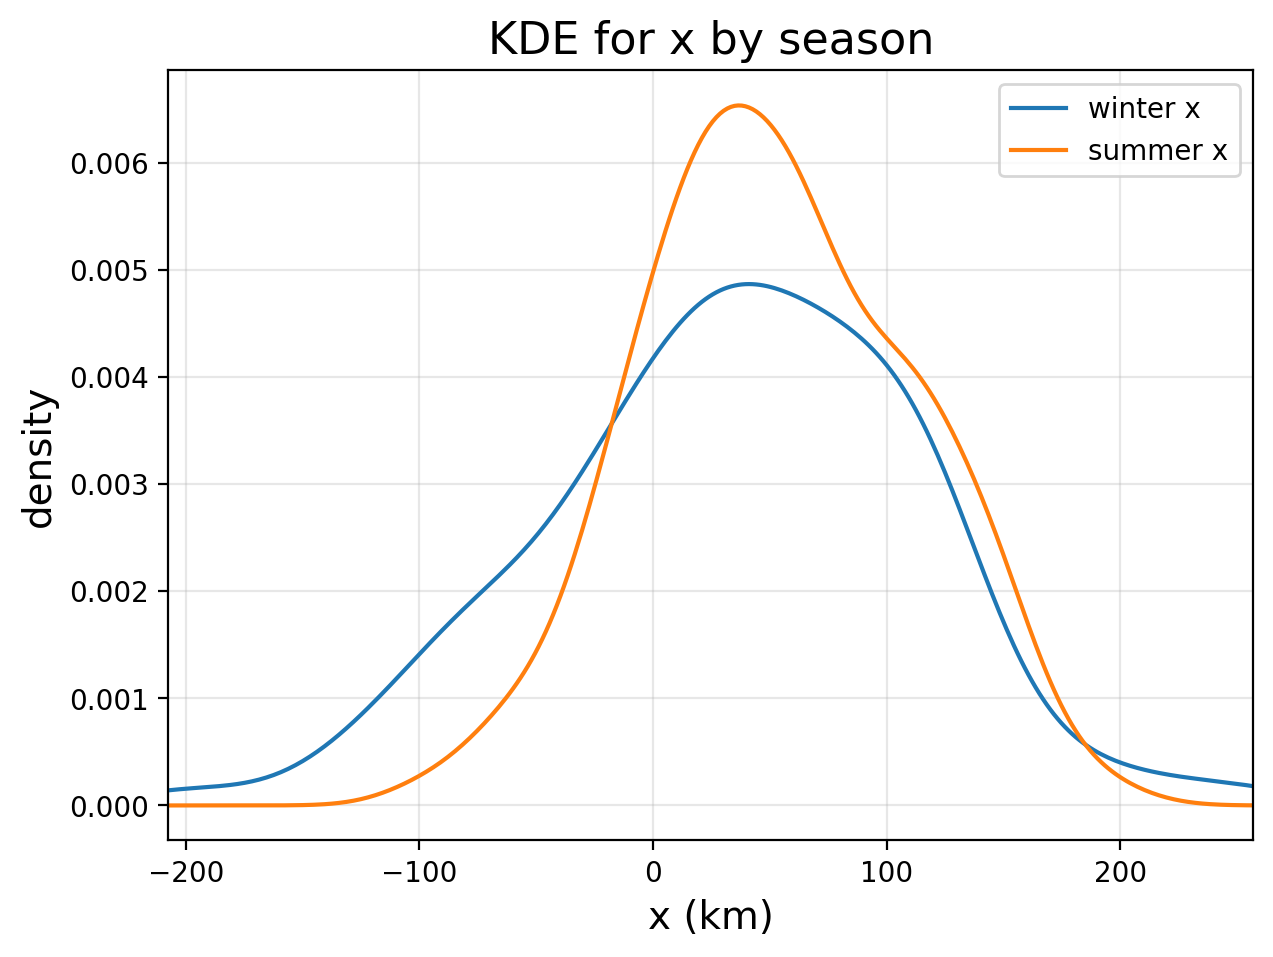

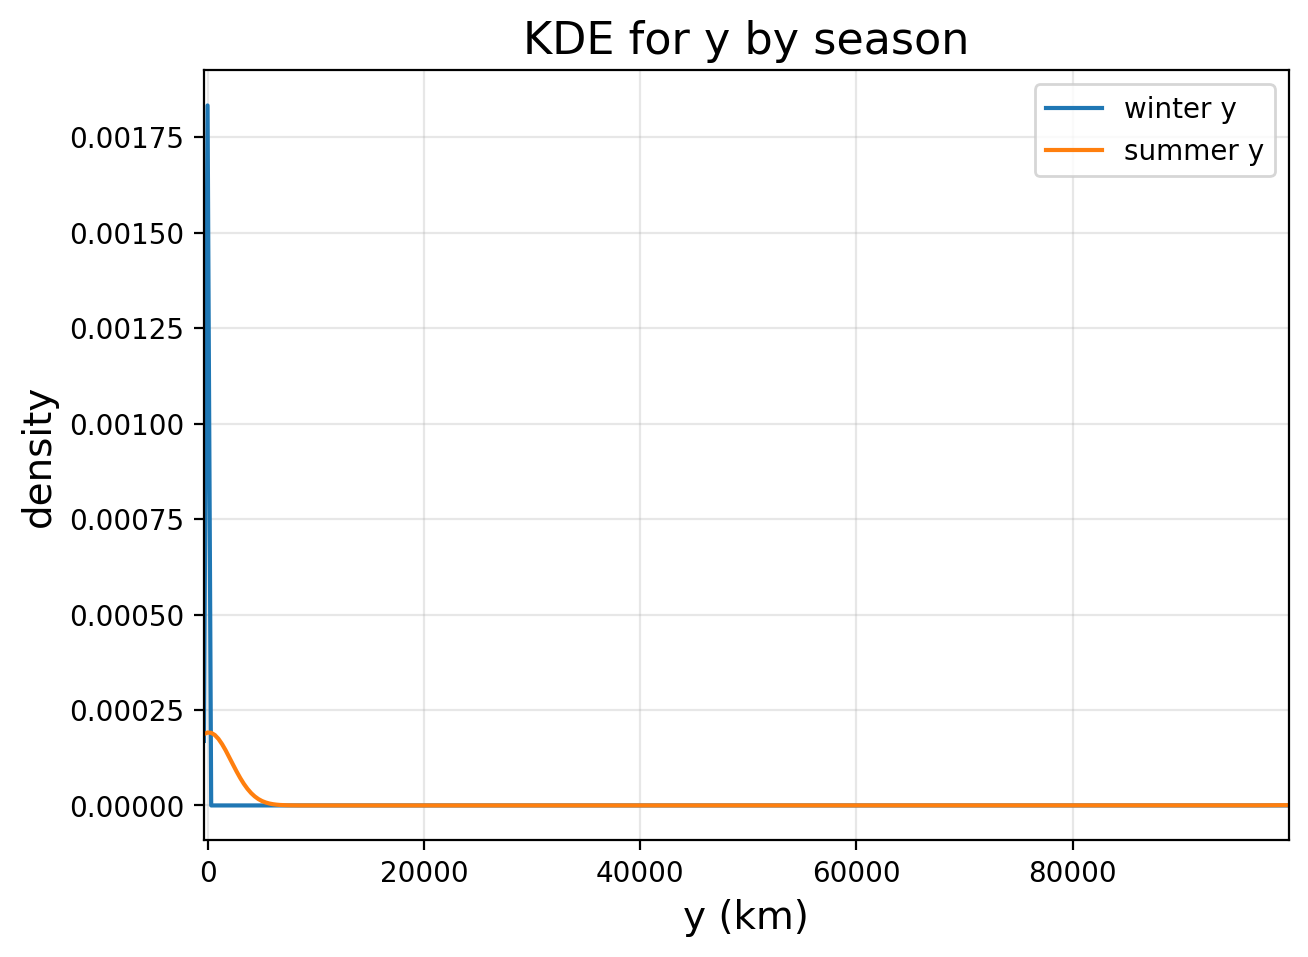

In [26]:
def kde_overlay(v1, v2, lab1, lab2, xlab_txt, title_txt):
    kde1 = stats.gaussian_kde(v1)
    kde2 = stats.gaussian_kde(v2)
    x_min = np.min([v1.min(), v2.min()])
    x_max = np.max([v1.max(), v2.max()])
    x_plot = linspace(x_min, x_max, 300)
    figure(1, [7,5])
    plot(x_plot, kde1(x_plot), label=lab1)
    plot(x_plot, kde2(x_plot), label=lab2)
    xlabel(xlab_txt, fontsize=14)
    ylabel("density", fontsize=14)
    title(title_txt, fontsize=16)
    xlim([x_min, x_max])
    legend()
    grid(alpha=0.3)
    show()

kde_overlay(winter["x"].values, summer["x"].values,
            "winter x", "summer x",
            "x (km)", "KDE for x by season")
kde_overlay(winter["y"].values, summer["y"].values,
            "winter y", "summer y",
            "y (km)", "KDE for y by season")

E

**Distribution choice with explanation:**

Based on (i) our season-separated scatter plot and (ii) the x KDE being unimodal/bell-shaped, the most defensible model is:

Model choice

For each season
𝑠
∈
{
𝑆
,
𝑊
}
s∈{S,W},

 model sightings as coming from a **2D Gaussian “cloud” Distribution** centered at the seasonal den:

𝑥
𝑖
,
𝑠
∼
Normal
(
𝜇
𝑥
,
𝑠
,
𝜎
𝑥
,
𝑠
)


𝑦
𝑖
,
𝑠
∼
Normal
(
𝜇
𝑦
,
𝑠
,
𝜎
𝑦
,
𝑠
)


 (𝜇𝑥,𝑆,𝜇𝑦,𝑆) = Summer den position

 (𝜇𝑥,W,𝜇𝑦,W) = Winter den position


 **Why this matches Our observations:**

The two clusters in the scatter plot strongly imply two different means (two den centers).

The seasonal clusters are roughly elliptical and axis-aligned
→ independence is a reasonable simplifying assumption:

Equivalent to a multivariate normal with diagonal covariance

The KDE for x supports Normal marginals.


F

 **Priors + prior predictive checks With Explanations**

 **Goal**

Choose informative but not overly restrictive priors for den location and wandering scale, then validate them with prior predictive plots.

**how i did this:**

Used empirical mean and standard deviation from each season as a starting reference:

𝜇
𝑥
,
𝑠
μ
x,s
	​

 prior centered near sample mean
𝑚
𝑥
,
𝑠
m
x,s
	​


𝜇
𝑦
,
𝑠
μ
y,s
	​

 prior centered near sample mean
𝑚
𝑦
,
𝑠
m
y,s
	​


Set mean priors:

μx,s​∼Normal(mx,s​,wide),μy,s​∼Normal(my,s​,wide)

where “wide” was chosen as about half the observed SD (with a minimum of 5 km).

Set scale priors using Exponential distributions:

σ
x,s
	​

∼Exponential(λ=1/scale),σ
y,s
	​

∼Exponential(λ=1/scale)

with scale tied to observed variability.

Prior predictive check (your hist overlays)

You simulated many plausible datasets from the priors and overlaid them on observed histograms.

Observation: the prior predictive distributions were broad enough to cover the observed range, meaning:

priors are not “cheating” by forcing the posterior
but they remain plausible for the park context

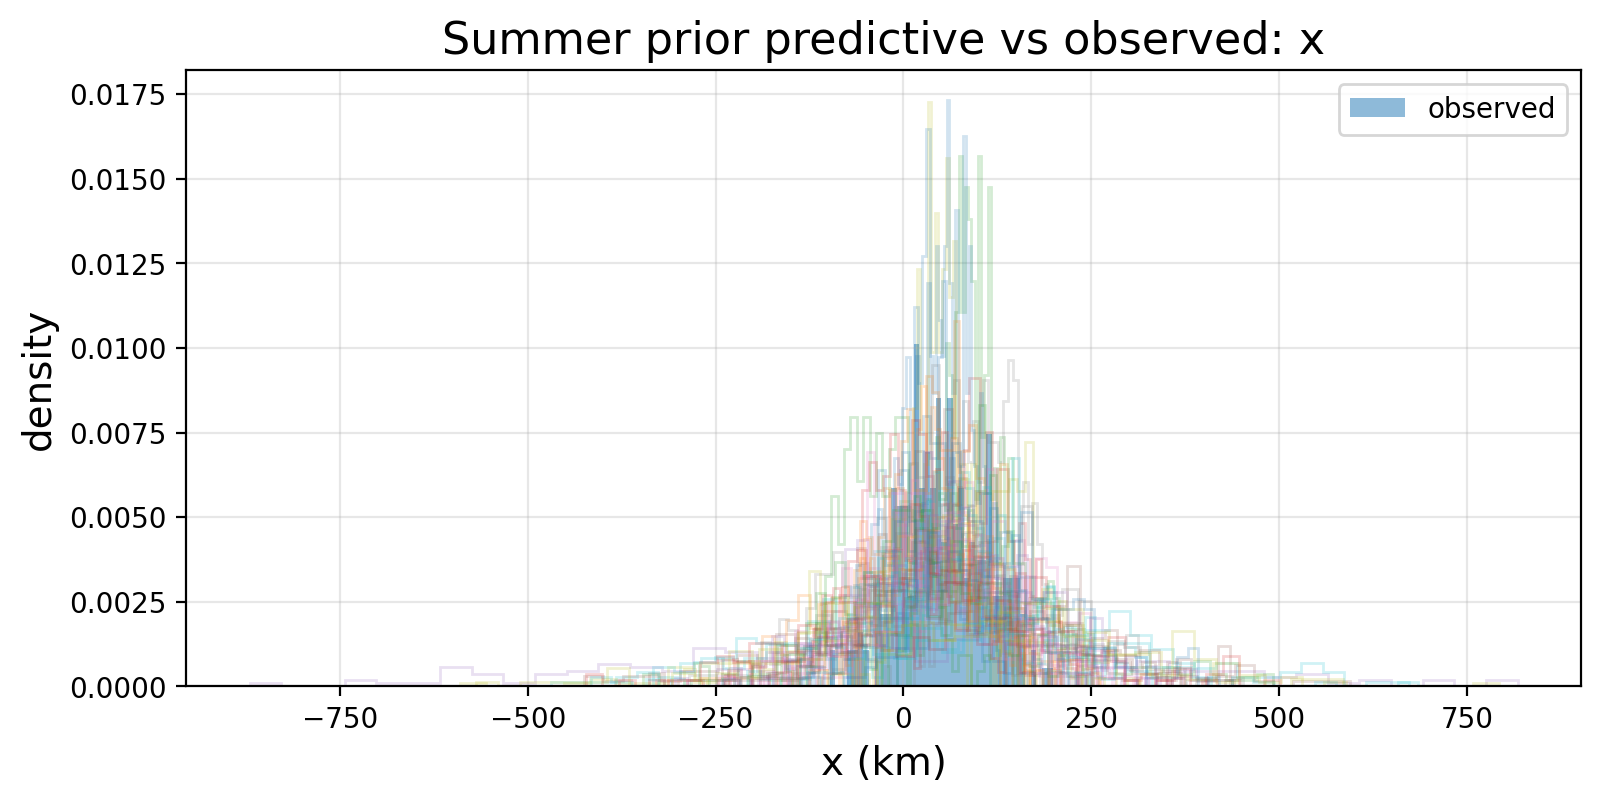

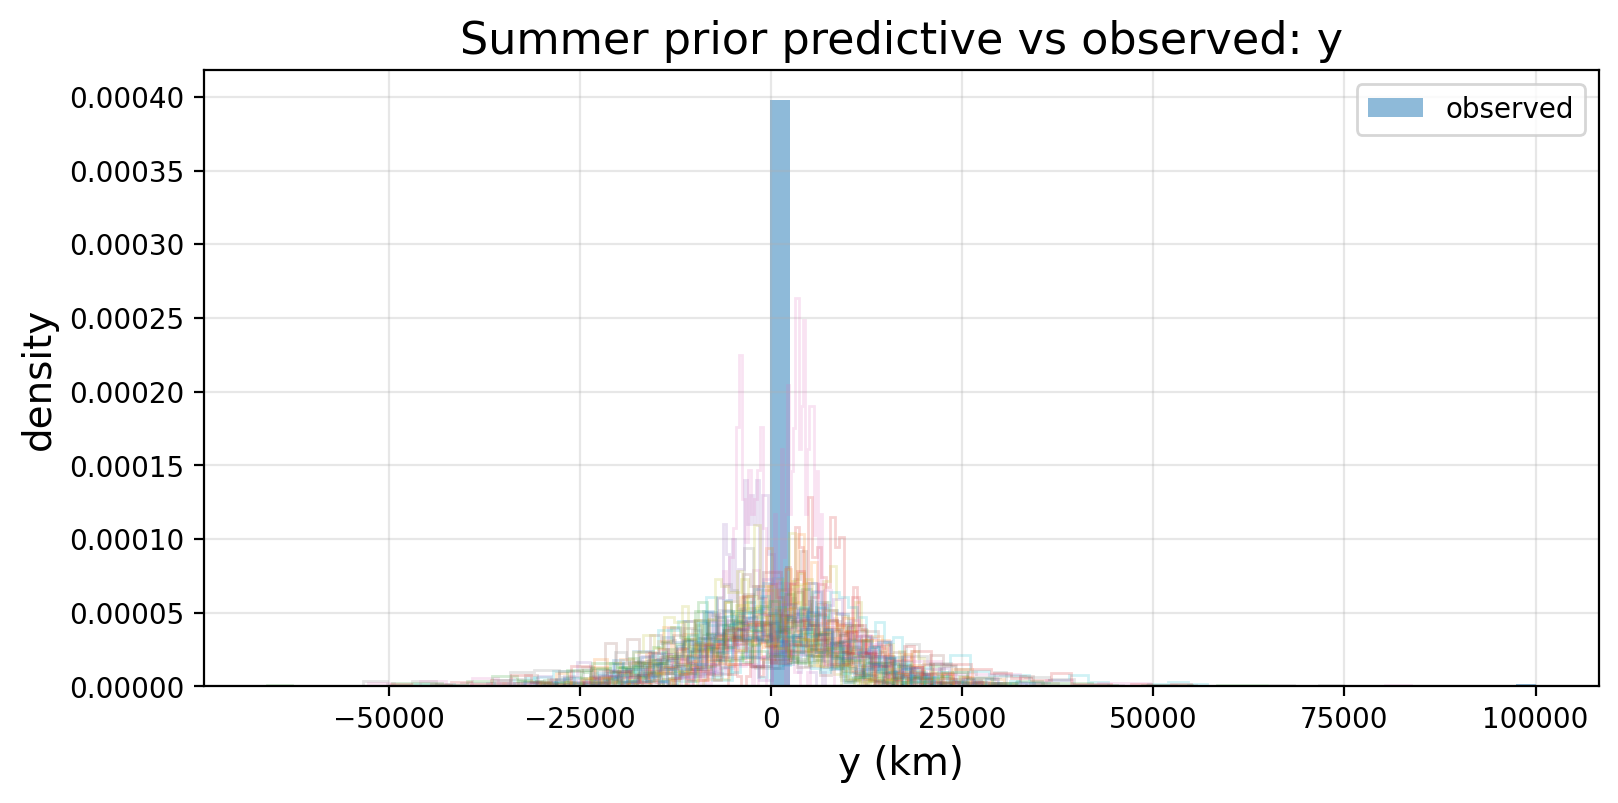

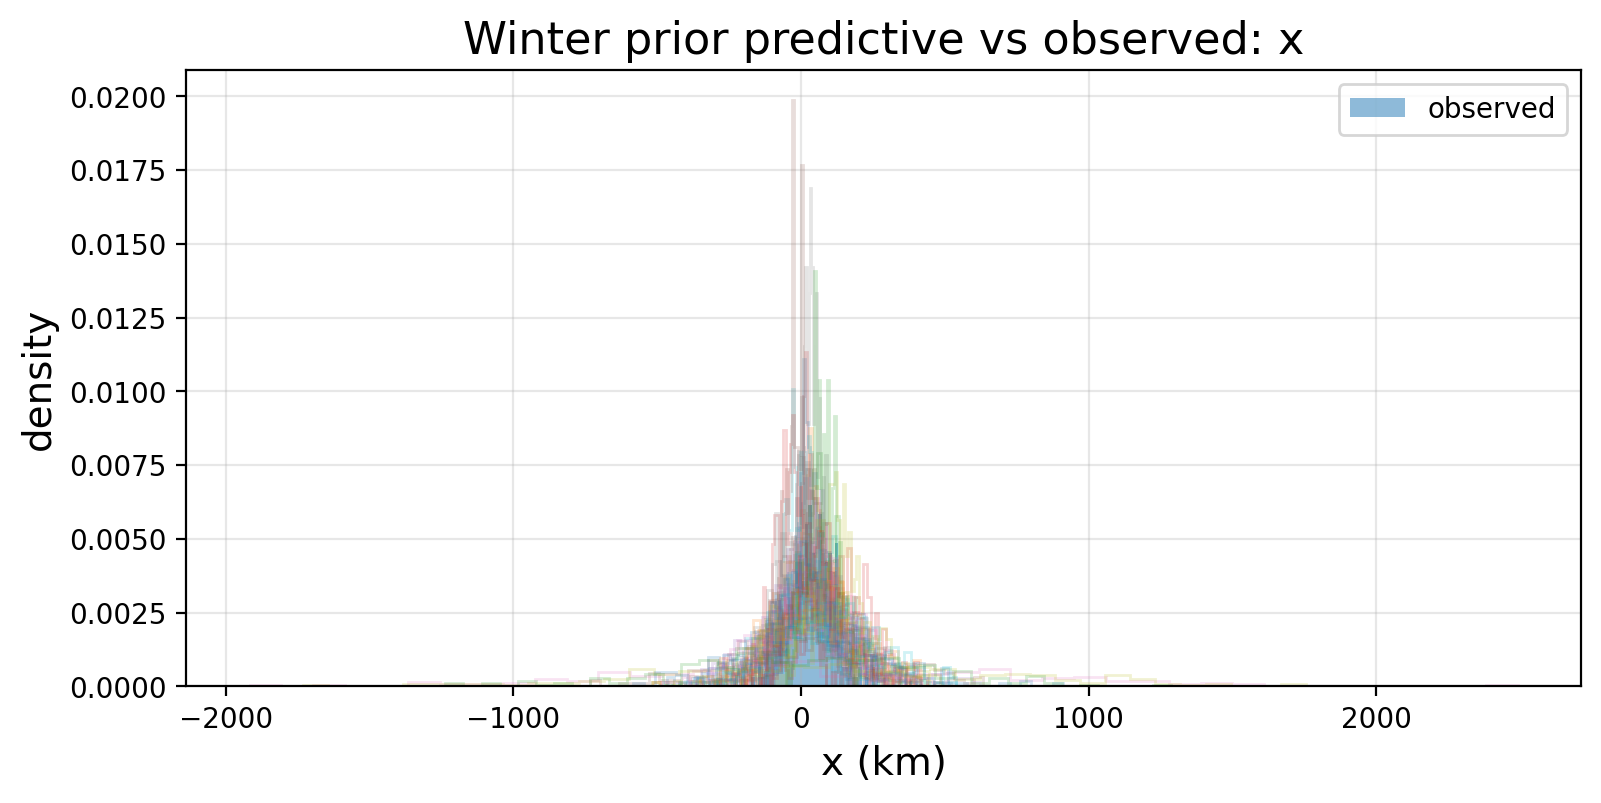

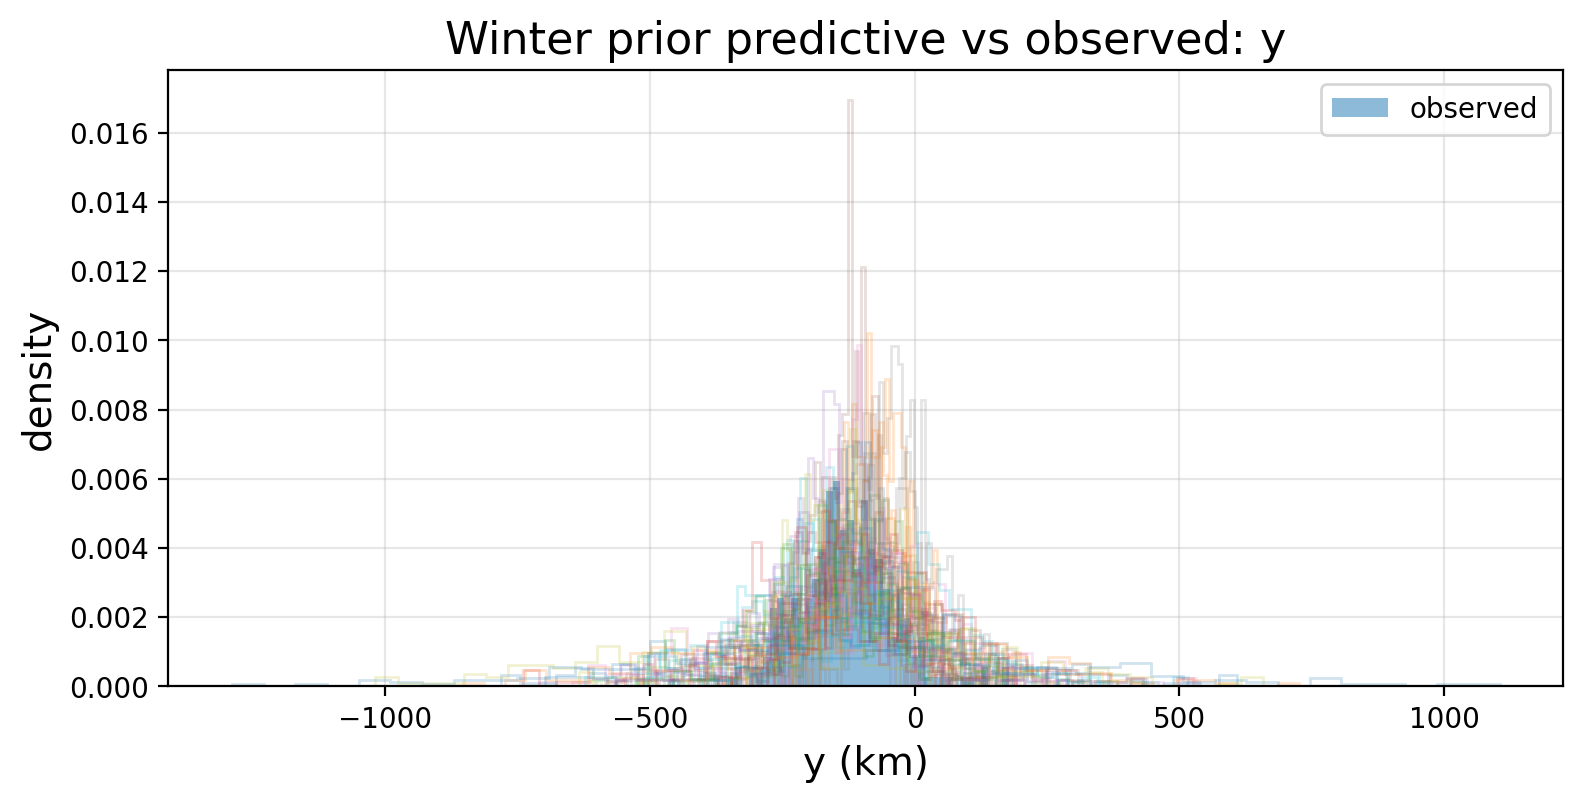

In [27]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

mx_S = summer["x"].mean()
sx_S = summer["x"].std(ddof=1)
my_S = summer["y"].mean()
sy_S = summer["y"].std(ddof=1)

mx_W = winter["x"].mean()
sx_W = winter["x"].std(ddof=1)
my_W = winter["y"].mean()
sy_W = winter["y"].std(ddof=1)

mu_sd_x_S = np.maximum(5.0, 0.5 * sx_S)
mu_sd_y_S = np.maximum(5.0, 0.5 * sy_S)
mu_sd_x_W = np.maximum(5.0, 0.5 * sx_W)
mu_sd_y_W = np.maximum(5.0, 0.5 * sy_W)

sig_med_x_S = np.maximum(1e-3, 1.5 * sx_S)
sig_med_y_S = np.maximum(1e-3, 1.5 * sy_S)
sig_med_x_W = np.maximum(1e-3, 1.5 * sx_W)
sig_med_y_W = np.maximum(1e-3, 1.5 * sy_W)

sigma_log_sd = 0.5

def prior_predictive(mx, my, mu_sd_x, mu_sd_y, sig_scale_x, sig_scale_y, n, draws=60):
    mux = stats.norm.rvs(loc=mx, scale=mu_sd_x, size=draws)
    muy = stats.norm.rvs(loc=my, scale=mu_sd_y, size=draws)
    sigx = np.exp(stats.norm.rvs(loc=np.log(sig_scale_x), scale=sigma_log_sd, size=draws)) # Corrected sig_med_x to sig_scale_x
    sigy = np.exp(stats.norm.rvs(loc=np.log(sig_scale_y), scale=sigma_log_sd, size=draws)) # Corrected sig_med_y to sig_scale_y
    x_pp = stats.norm.rvs(loc=mux[:, None], scale=sigx[:, None], size=(draws, n))
    y_pp = stats.norm.rvs(loc=muy[:, None], scale=sigy[:, None], size=(draws, n))

    return x_pp, y_pp

xS_pp, yS_pp = prior_predictive(mx_S, my_S, mu_sd_x_S, mu_sd_y_S, sig_med_x_S, sig_med_y_S,
                                   summer.shape[0], draws=50)

xW_pp, yW_pp = prior_predictive(mx_W, my_W, mu_sd_x_W, mu_sd_y_W, sig_med_x_W, sig_med_y_W,
                                   winter.shape[0], draws=50)


def overlay_hist(obs, pp, title_txt, xlabel_txt):
    figure(1, [9,4])
    hist(obs, bins=40, density=True, alpha=0.5, label="observed")
    for k in range(pp.shape[0]):
        hist(pp[k], bins=40, density=True, histtype="step", alpha=0.2)
    title(title_txt, fontsize=16)
    xlabel(xlabel_txt, fontsize=14)
    ylabel("density", fontsize=14)
    legend()
    grid(alpha=0.3)
    show()

overlay_hist(summer["x"].values, xS_pp, "Summer prior predictive vs observed: x", "x (km)")
overlay_hist(summer["y"].values, yS_pp, "Summer prior predictive vs observed: y", "y (km)")
overlay_hist(winter["x"].values, xW_pp, "Winter prior predictive vs observed: x", "x (km)")
overlay_hist(winter["y"].values, yW_pp, "Winter prior predictive vs observed: y", "y (km)")

G

**Posterior sampling + KDE of mean squared distance (MSD)**

Goal
Use MCMC to estimate uncertainty in how far wolves wander from the den, separately for:

x-direction (east/west) and y-direction (north/south)

summer and winter

That is four posterior distributions with four plots:

**What I observed (from my posterior plots)**

Winter MSDs (especially in y) appear larger than summer MSDs → wolves spread further in winter.

The posterior shapes are unimodal and fairly tight, meaning the data are informative about variability.

Small fix for maximum grade: your notebook shows posterior KDEs for winter x, winter y, and summer x. You should also explicitly plot summer MSD in y (even if it was created—sometimes the output didn’t render).



Output()

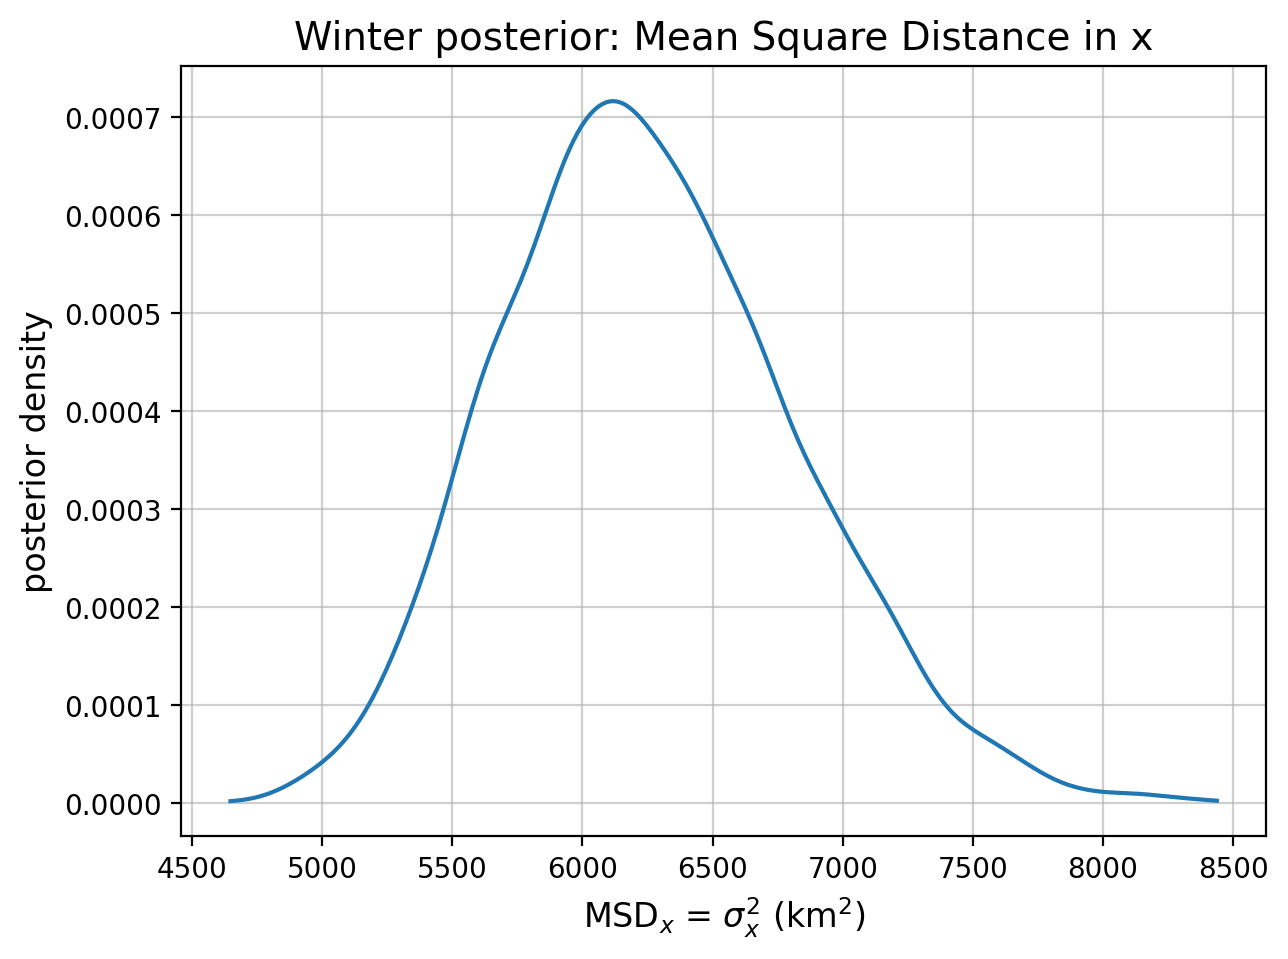

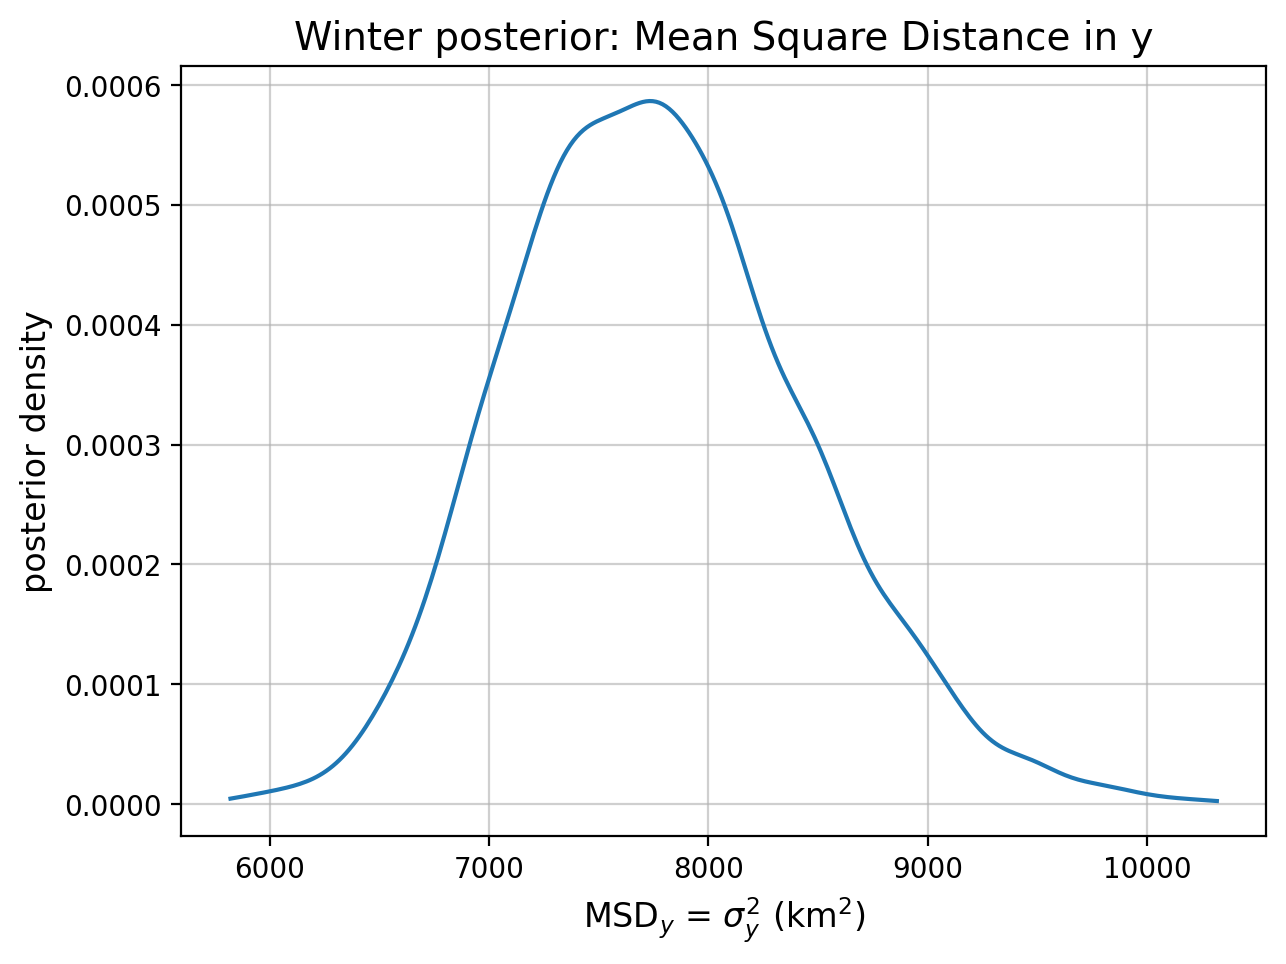

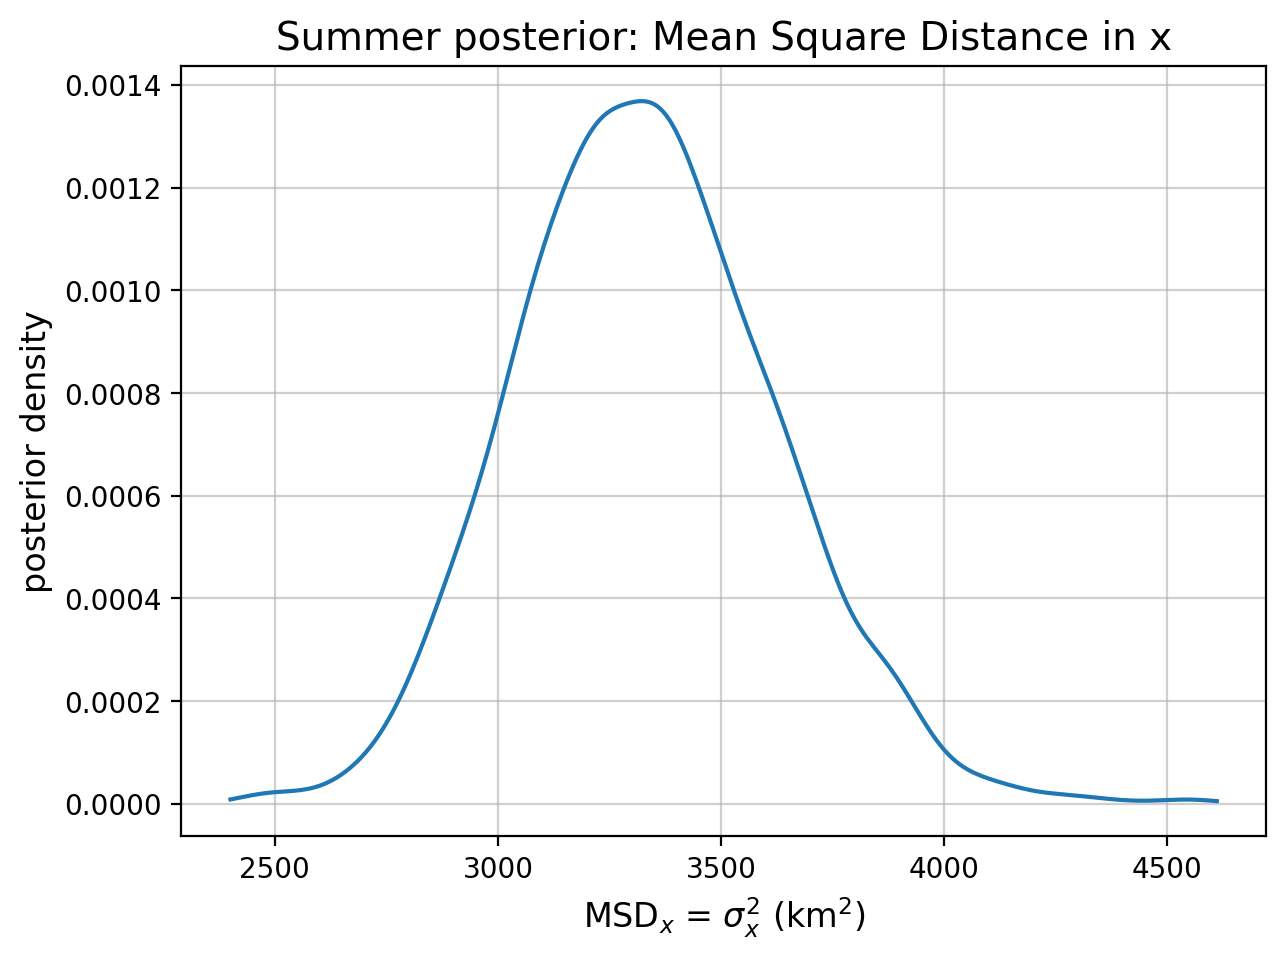

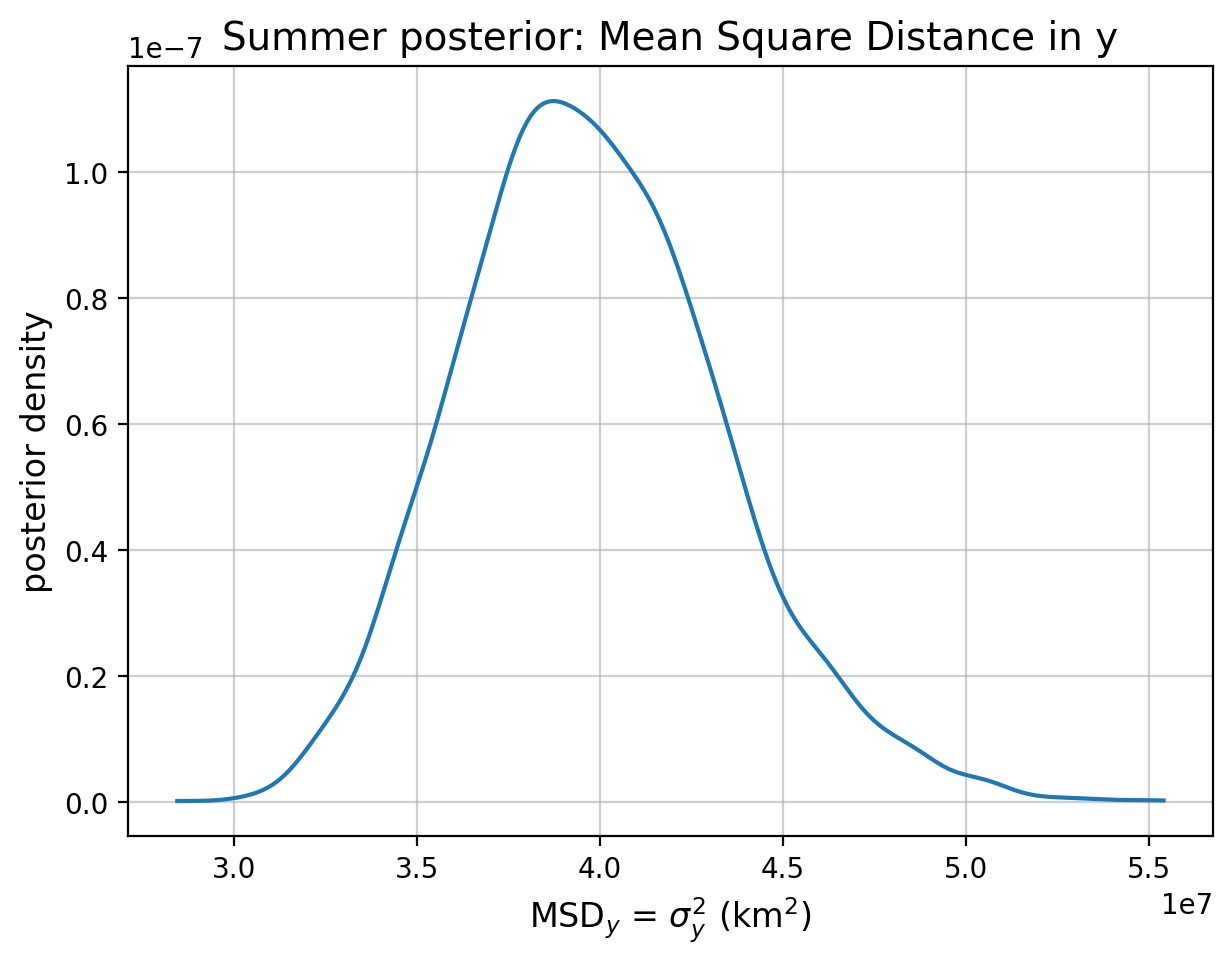

In [30]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
xS = summer["x"].values
yS = summer["y"].values
xW = winter["x"].values
yW = winter["y"].values
with pm.Model() as model:
  mux_S = pm.Normal("mux_S", mu=mx_S, sigma=mu_sd_x_S)
  muy_S = pm.Normal("muy_S", mu=my_S, sigma=mu_sd_y_S)
  sigx_S = pm.Exponential("sigx_S", lam=1.0 / sig_med_x_S)
  sigy_S = pm.Exponential("sigy_S", lam=1.0 / sig_med_y_S)
  mux_W = pm.Normal("mux_W", mu=mx_W, sigma=mu_sd_x_W)
  muy_W = pm.Normal("muy_W", mu=my_W, sigma=mu_sd_y_W)
  sigx_W = pm.Exponential("sigx_W", lam=1.0 / sig_med_x_W)
  sigy_W = pm.Exponential("sigy_W", lam=1.0 / sig_med_y_W)

  pm.Normal("xS_obs", mu=mux_S, sigma=sigx_S, observed=xS)
  pm.Normal("yS_obs", mu=muy_S, sigma=sigy_S, observed=yS)
  pm.Normal("xW_obs", mu=mux_W, sigma=sigx_W, observed=xW)
  pm.Normal("yW_obs", mu=muy_W, sigma=sigy_W, observed=yW)
  msd_x_S = pm.Deterministic("msd_x_S", sigx_S**2)
  msd_y_S = pm.Deterministic("msd_y_S", sigy_S**2)
  msd_x_W = pm.Deterministic("msd_x_W", sigx_W**2)
  msd_y_W = pm.Deterministic("msd_y_W", sigy_W**2)
  trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=RANDOM_SEED
    )
def posterior_kde(samples, title, xlabel):
    s = np.asarray(samples)
    kde = stats.gaussian_kde(s)
    x_grid = np.linspace(s.min(), s.max(), 300)
    plt.figure(figsize=(7, 5))
    plt.plot(x_grid, kde(x_grid))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("posterior density", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

msd_x_W_draws = trace.posterior["msd_x_W"].values.flatten()
msd_y_W_draws = trace.posterior["msd_y_W"].values.flatten()
msd_x_S_draws = trace.posterior["msd_x_S"].values.flatten()
msd_y_S_draws = trace.posterior["msd_y_S"].values.flatten()

posterior_kde(msd_x_W_draws, "Winter posterior: Mean Square Distance in x", r"MSD$_x$ = $\sigma_x^2$ (km$^2$)")
posterior_kde(msd_y_W_draws, "Winter posterior: Mean Square Distance in y", r"MSD$_y$ = $\sigma_y^2$ (km$^2$)")
posterior_kde(msd_x_S_draws, "Summer posterior: Mean Square Distance in x", r"MSD$_x$ = $\sigma_x^2$ (km$^2$)")
posterior_kde(msd_y_S_draws, "Summer posterior: Mean Square Distance in y", r"MSD$_y$ = $\sigma_y^2$ (km$^2$)")